# Wikipedia co-authorship network
## A Network Science Project


#Introduction to the project problem

Wikipedia is a trove of knowledge, where various articles are created and edited multiple times by multiple people. Thus an article represents a cumulative effort of several co-authors. As we define the notion of co-authorship, we can also define a network representing this. In addition, the networks can be created for each respective year, resulting in a series of networks. 

It is the goal of this project to look for communities of co-authors, to plot the size distribution of the groups and see how they change over time. 

#Defining the network
In order to create our network, first we need to look at what consitutes a Wikipedia article revision. For every edit made on an article, there is various information of use that is stored; this includes the ID of the article revised, timestamp, contributor who made the edit (note that this is either the username of the editor or their IP adress if they made the edit without logging in), number of bytes changed in the article, a comment describing the edit...

The article ID, contirbutor and timestamps will be used to generate the graphs.


##Importing and splitting the data
In this project, the Bosnian Wikipedia revison data was used and processed locally to remove revisions in wikipedia namespaces that aren't articles, resulting in almost ~890,000 records. The original data dump was in a xml format and featured almost three million records, which were transformed to a .csv file using wiki-dump-parser python script.     

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse
from scipy.stats import rankdata
from sklearn.preprocessing import normalize

from scipy.sparse import lil_matrix
from networkx.readwrite import json_graph

from networkx.algorithms import community
from networkx import edge_betweenness_centrality as betweenness
from networkx.algorithms.community import greedy_modularity_communities
from networkx.classes.function import density
from networkx.algorithms.components import number_connected_components
from networkx.algorithms.community import k_clique_communities

Read the data while skipping corrupted records...

In [ ]:
df = pd.read_csv('BSdump.csv', quotechar='|', index_col = False,sep = ';', 
                 skiprows=[12216,18472,29168,40022,51521,123351,175366,181970,183795,186015,250248,
                           276528,323973,344667,351008,417912,445169,461519,498298,526367,546163,
                           555601,557889,582426,603950,608912,609053,612523,612985,612986,623082,
                           633435,656718,660150,674747,674750,680325,696620,697820,718052,726331,
                           726450,726452,739211,751618,755051,759810,767080,767660,768243,795025,
                           824717,828718,828756,829519,829671,829672,831183,833409,865939,871026,])


Reformating timestamps into year only information.
Dropping duplicate revisions - edits made by the same contributor on a particular article within the same year. This brings the total amount of revisions to over 500,000. 

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'],format='%Y-%m-%dT%H:%M:%SZ')
df['timestamp'] = df['timestamp'].dt.year
df.drop(columns=['Unnamed: 6','revision_id'],inplace=True)
df = df.drop_duplicates()
df.dropna()
df.sort_values(by='timestamp', ascending=True,inplace=True)

Notice that some of these revisions are minor edits made by the bots. We'll come back to this later.

In [ ]:
df

,page_id,page_title,timestamp,contributor_id,contributor_name
0,7,Matematika,2002,1,Pingos~bswiki
356,24,Fizika,2002,1,Pingos~bswiki
363,24,Fizika,2002,216.232.122.204,Anonymous
602,25,Kalendar,2002,1,Pingos~bswiki
216,9,Skulptura,2002,1,Pingos~bswiki
...,...,...,...,...,...
77222,2011,60.,2021,120674,WumpusBot
476130,10982,Karl Ferdinand Braun,2021,118070,InternetArchiveBot
743114,22427,Anis,2021,126033,NeptuneBot
588794,15476,Bošnjačko-hrvatski sukob,2021,120674,WumpusBot


Let's look into the distribution of revisions per year. We can see that there was a large amount of edits in the year 2006-2009, slowly tapering off the following four years and further decreasing to a more stable level of under 10,000 revisions per year. 

In [ ]:
print(df['timestamp'].value_counts(sort=False))

2002        6
2003      132
2004     2510
2005    18211
2006    59657
2007    68888
2008    63187
2009    62902
2010    50052
2011    47212
2012    46614
2013    38695
2014    12997
2015    11215
2016     8215
2017     8091
2018     7355
2019     9151
2020     9802
2021     7860
Name: timestamp, dtype: int64


Since our goal is to create a series of networks for each year, we'll split our data accordingly.

In [ ]:
UniqueYears = df.timestamp.unique()
DataFrameDict = {elem : pd.DataFrame for elem in UniqueYears}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df[:][df.timestamp == key]

In [ ]:
DataFrameDict

{2002:      page_id         page_title  timestamp   contributor_id contributor_name
 0          7         Matematika       2002                1    Pingos~bswiki
 356       24             Fizika       2002                1    Pingos~bswiki
 363       24             Fizika       2002  216.232.122.204        Anonymous
 602       25           Kalendar       2002                1    Pingos~bswiki
 216        9          Skulptura       2002                1    Pingos~bswiki
 297       10  Scenska umjetnost       2002                1    Pingos~bswiki,
 2003:       page_id   page_title  timestamp   contributor_id contributor_name
 5506       88  Gravitacija       2003                1    Pingos~bswiki
 2908       47        1353.       2003               10          Traroth
 2909       47        1353.       2003               24           Hashar
 2990       48        1391.       2003                1    Pingos~bswiki
 2991       48        1391.       2003               10          Traroth
 ..

## Creating the graphs

The following is the function created for generating the nodes, edges and edge weights of the graph for a given year. 




*   Nodes are individual users who make revisions. For each article we go through all its revisions in the given year finding all the users who made a revision. 
*   Edges are formed while forming the nodes. Between every pair of users who made revisions on the same article in the same year, an edge will be drawn. This way we immediately forgo isolated nodes - contributors who did not co-operate with anyone else, as these users are not of interest to us.
* Edge weights represent the amount of article two connecting users worked together on. The higher the weight, the stronger their co-operation.



In [ ]:
def yearly_graph(year):
  UniquePages = DataFrameDict[year].page_id.unique()
  DataFrameDictPages = {elem : pd.DataFrame for elem in UniquePages}
  for key in DataFrameDictPages.keys():
      DataFrameDictPages[key] = DataFrameDict[year][:][DataFrameDict[year].page_id == key]

  dol = pd.DataFrame(columns=["source","target","weight","year"])

  for key in DataFrameDictPages.keys():
    cidlist= [cid for cid in DataFrameDictPages[key]['contributor_id']]
    cidlist.sort()
    cidlist = np.array(cidlist)

    for i in range(len(cidlist)-1):
      for j in range(1,len(cidlist)):
        if ((dol['source'] == cidlist[i]) & (dol['target'] == cidlist[j])).any():
          index_list = dol[(dol['source'] == cidlist[i])&(dol['target'] == cidlist[j])].index.tolist()[0]
          dol.at[index_list,"weight"]=dol.at[index_list,"weight"]+1
        else:
          dol.loc[dol.shape[0]]=[cidlist[i],cidlist[j],1,year]  

  index_list = dol[(dol['source'] ==  dol['target'] )].index.tolist()
  dol = dol.drop(index=index_list)
  
  G = nx.from_pandas_edgelist(dol, "source", "target", ["weight", "year"])
  cc_year = DataFrameDict[year].drop(columns=['page_id','page_title','timestamp']).drop_duplicates()
  cc_year =  cc_year[cc_year["contributor_name"].str.contains("Anonymous")==False]
  cont_name_dict = dict([(k,v ) for k,v in zip(cc_year.contributor_id,cc_year.contributor_name)])
  #print (cont_name_dict)
  G = nx.relabel_nodes(G, cont_name_dict)
  return G

Because creating this data from the .csv file takes a long time (e.g. 4h~ for year 2007) the graphs are made once and exported as a .json file. Later when working with these graphs we can simply import them from these saved files.

##Generate exports

In [ ]:
def export_graph(G,year):
  data1 = json_graph.node_link_data(G)
  with open(str(year)+'.json', 'w', encoding='utf-8') as f:
      json.dump(data1, f, ensure_ascii=False, indent=4)

In [ ]:
G_2003=yearly_graph(2003)
export_graph(G_2003,2003)

In [ ]:
G_2004=yearly_graph(2004)
export_graph(G_2004,2004)

In [ ]:
G_2005=yearly_graph(2005)
export_graph(G_2005,2005)

In [ ]:
G_2006=yearly_graph(2006)
export_graph(G_2006,2006)

In [ ]:
G_2007=yearly_graph(2007)
export_graph(G_2007,2007)

In [ ]:
G_2008=yearly_graph(2008)
export_graph(G_2008,2008)

In [ ]:
G_2009=yearly_graph(2009)
export_graph(G_2009,2009)

In [ ]:
G_2010=yearly_graph(2010)
export_graph(G_2010,2010)

In [ ]:
G_2011=yearly_graph(2011)
export_graph(G_2011,2011)

In [ ]:
G_2012=yearly_graph(2012)
export_graph(G_2012,2012)

In [ ]:
G_2013=yearly_graph(2013)
export_graph(G_2013,2013)

In [ ]:
G_2014=yearly_graph(2014)
export_graph(G_2014,2014)

In [ ]:
G_2015=yearly_graph(2015)
export_graph(G_2015,2015)

In [ ]:
G_2016=yearly_graph(2016)
export_graph(G_2016,2016)

In [ ]:
G_2017=yearly_graph(2017)
export_graph(G_2017,2017)

In [ ]:
G_2018=yearly_graph(2018)
export_graph(G_2018,2018)

In [ ]:
G_2019=yearly_graph(2019)
export_graph(G_2019,2019)

In [ ]:
G_2020=yearly_graph(2020)
export_graph(G_2020,2020)

In [ ]:
G_2021=yearly_graph(2021)
export_graph(G_2021,2021)

##Import graphs

In [4]:
def import_graph(year):
  with open(str(year)+'.json') as f:
      ddata1 = json.load(f)
  return json_graph.node_link_graph(ddata1)

In [5]:
G_2003 = import_graph(2003)
G_2004 = import_graph(2004)
G_2005 = import_graph(2005)
G_2006 = import_graph(2006)
G_2007 = import_graph(2007)
G_2008 = import_graph(2008)
G_2009 = import_graph(2009)
G_2010 = import_graph(2010)
G_2011 = import_graph(2011)
G_2012 = import_graph(2012)
G_2013 = import_graph(2013)
G_2014 = import_graph(2014)
G_2015 = import_graph(2015)
G_2016 = import_graph(2016)
G_2017 = import_graph(2017)
G_2018 = import_graph(2018)
G_2019 = import_graph(2019)
G_2020 = import_graph(2020)
G_2021 = import_graph(2021)

# Basic network properties
Let's take a look at some basic network properties and how they change throught the years.

In [10]:
info_per_year = pd.DataFrame(columns=["number_of_nodes","number_of_edges","average_degree",
                                       "number_components", "average_clustering"])
 
graphs_original=[G_2003,G_2004,G_2005,G_2006,G_2007,G_2008,G_2009,
        G_2010,G_2011,G_2012,G_2013,G_2014,G_2015,
        G_2016,G_2017,G_2018,G_2019,G_2020,G_2021]

for year in range(2003,2022):
  info_per_year.loc[year]=[graphs_original[year-2003].number_of_nodes(),graphs_original[year-2003].number_of_edges(),                                
                           np.mean([d for _, d in graphs_original[year-2003].degree()]),
                         nx.number_connected_components(graphs_original[year-2003]),nx.average_clustering(graphs_original[year-2003])]

We can clearly which years have more prolific contributors (2006 and 2007). And we can also see that the size of the network slowly stagnates in the last few years, especially after 2013. In most cases the more users were present contributing in a year, the more connections, but there are minor exceptions such as year 2013. This tells us that a great deal of articles were created and edited in the begining of this wikipedia's life as it was built, but in the later years it's more about maintaining the said wiki.
We can notice another particular trend of the co-autorships growing weaker after 2013 by looking at the drop in the average degree for these graphs and the uptick in the number of connected components. 

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(info_per_year)

      number_of_nodes  number_of_edges  average_degree  number_components  \
2003             32.0             84.0        5.250000                1.0   
2004            533.0           7826.0       29.365854                3.0   
2005           2251.0          28351.0       25.189693               12.0   
2006           5484.0          67724.0       24.698760                1.0   
2007           5699.0          69932.0       24.541849                6.0   
2008           4191.0          47250.0       22.548318                9.0   
2009           3566.0          39914.0       22.385867                5.0   
2010           2917.0          24196.0       16.589647                6.0   
2011           2408.0          21816.0       18.119601                7.0   
2012           2393.0          21249.0       17.759298                2.0   
2013           2584.0          17822.0       13.794118                1.0   
2014           1807.0           6494.0        7.187604               19.0   

Visualising these properties on barcharts...

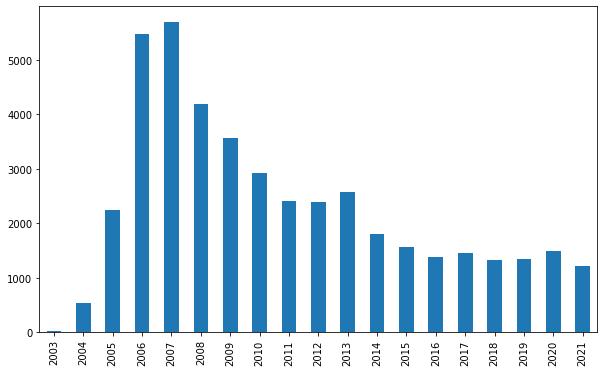

In [ ]:
info_per_year["number_of_nodes"].plot(kind='bar',figsize=(10,6))

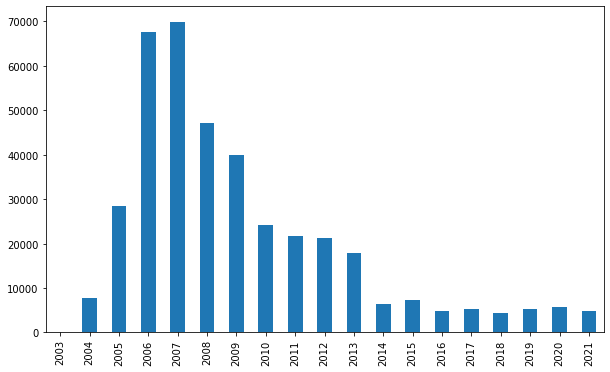

In [ ]:
info_per_year["number_of_edges"].plot(kind='bar',figsize=(10,6))

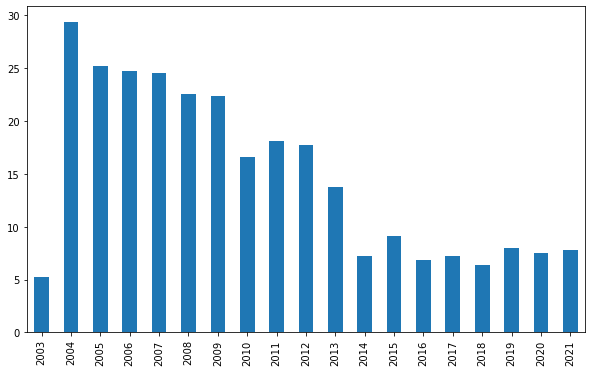

In [ ]:
info_per_year["average_degree"].plot(kind='bar',figsize=(10,6))

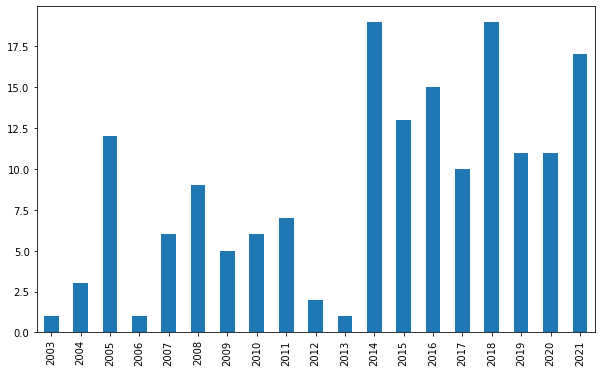

In [ ]:
info_per_year["number_components"].plot(kind='bar',figsize=(10,6))

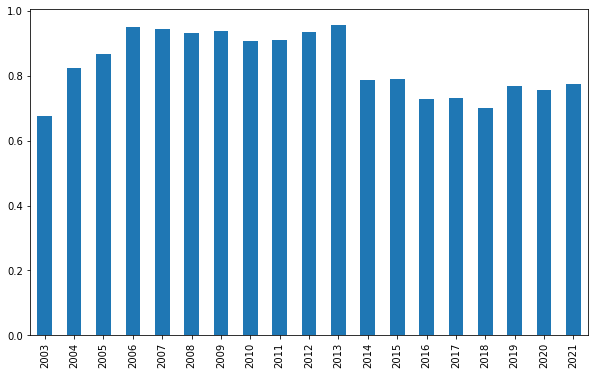

In [ ]:
info_per_year["average_clustering"].plot(kind='bar',figsize=(10,6))

## Removing the bots
We want to account for communities consisiting of *human* contributors. Luckily, these bot accounts making minor edits are easily recognised with the bot suffix, making it simple to remove them. Removing these bots may result in isolated nodes - users that made edits on articles where only a bot co-authored.
Although the number of these bot accounts is not large, their impact on the network is massive due to the large amount of edits made and co-authorship thus formed.

In [6]:
graphs=[G_2003.copy(),G_2004.copy(),G_2005.copy(),G_2006.copy(),G_2007.copy(),G_2008.copy(),G_2009.copy(),
        G_2010.copy(),G_2011.copy(),G_2012.copy(),G_2013.copy(),G_2014.copy(),G_2015.copy(),
        G_2016.copy(),G_2017.copy(),G_2018.copy(),G_2019.copy(),G_2020.copy(),G_2021.copy()]

In [7]:
info_per_year_snip = pd.DataFrame(columns=["number_of_nodes","number_of_edges","average_degree",
                                       "number_components", "average_clustering"])
 
for year in range(2003,2022):
  #edges_one = [(v,d) for v, d, a in graphs[year-2003].edges(data=True) if a['weight'] < 4]
  #graphs[year-2003].remove_edges_from(edges_one)

  bots = [a   for  a in graphs[year-2003].nodes() if a.endswith(tuple (['bot', 'BoT','Bot', 'BOT']))  ]
  graphs[year-2003].remove_nodes_from(bots)
  #graphs[year-2003].remove_nodes_from(list(nx.isolates(graphs[year-2003])))
  info_per_year_snip.loc[year]=[graphs[year-2003].number_of_nodes(),graphs[year-2003].number_of_edges(),
                                np.mean([d for _, d in graphs[year-2003].degree()]),
                         nx.number_connected_components(graphs[year-2003]),nx.average_clustering(graphs[year-2003])]
  
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(info_per_year_snip)                         

      number_of_nodes  number_of_edges  average_degree  number_components  \
2003             32.0             84.0        5.250000                1.0   
2004            531.0           7752.0       29.197740                3.0   
2005           2247.0          26627.0       23.700045               16.0   
2006           5472.0          50984.0       18.634503               21.0   
2007           5679.0          45030.0       15.858426              218.0   
2008           4144.0          23787.0       11.480212              161.0   
2009           3511.0          17661.0       10.060382              207.0   
2010           2852.0           9231.0        6.473352              267.0   
2011           2344.0           8406.0        7.172355              216.0   
2012           2328.0           7828.0        6.725086              273.0   
2013           2546.0           9821.0        7.714847              239.0   
2014           1801.0           5642.0        6.265408               65.0   

We can tell that bot accounts are just a minnor amount of nodes, but can make for a great deal of edges and thus the average degree. As bots were connecting a great deal of authors to themselves, more connected components have been formed for the graphs now (some are just isolated nodes), and we can also see a drop in the average clustering coefficient for some years too.
Let's visually represent the difference the bot accounts make, so we can see the impact properly.

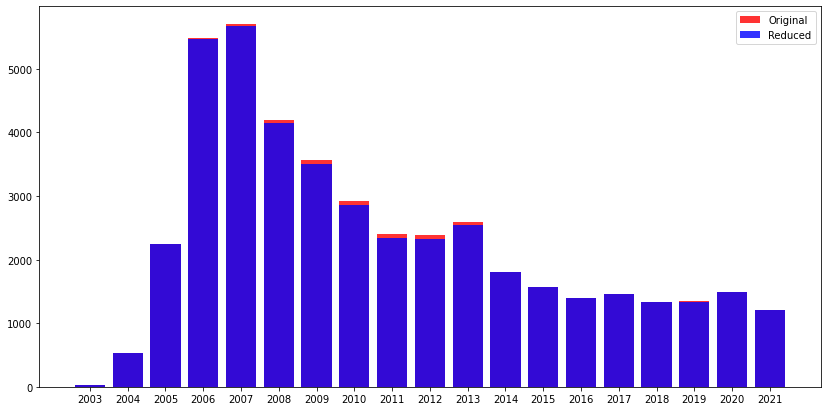

In [11]:
fig, ax = plt.subplots(figsize=(14,7))
years = [x for x in range(2003,2022)]
ax.bar(years, info_per_year["number_of_nodes"], linewidth=2.0,color='red',label='Original',alpha=0.8)
ax.bar(years, info_per_year_snip["number_of_nodes"], linewidth=2.0,color='blue',label='Reduced',alpha=0.8)
ax.legend()
ax.set(xticks=years)
plt.show()

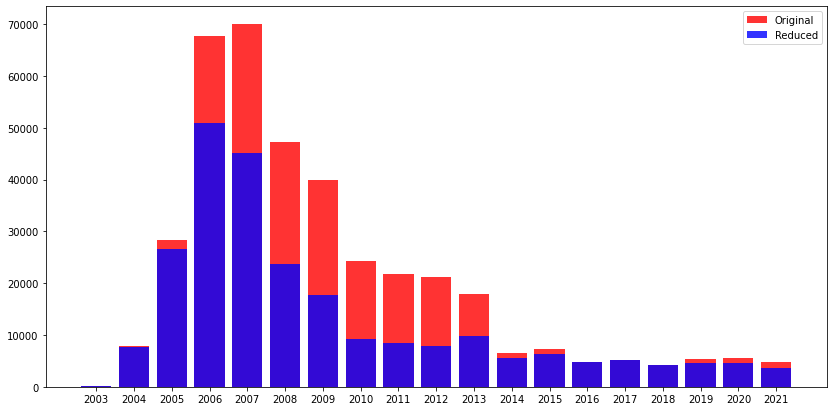

In [12]:
fig, ax = plt.subplots(figsize=(14,7))

years = [x for x in range(2003,2022)]
ax.bar(years, info_per_year["number_of_edges"], linewidth=2.0,color='red',label='Original',alpha=0.8)
ax.bar(years, info_per_year_snip["number_of_edges"], linewidth=2.0,color='blue',label='Reduced',alpha=0.8)
ax.legend()
ax.set(xticks=years)

plt.show()

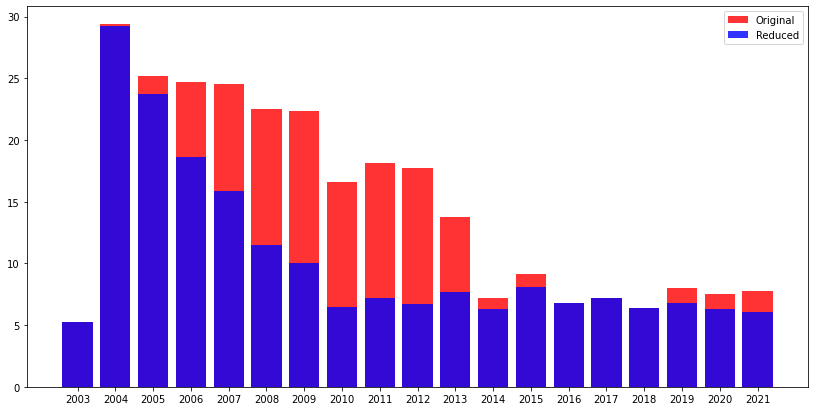

In [14]:
fig, ax = plt.subplots(figsize=(14,7))

years = [x for x in range(2003,2022)]
ax.bar(years, info_per_year["average_degree"], linewidth=2.0,color='red',label='Original',alpha=0.8)
ax.bar(years, info_per_year_snip["average_degree"], linewidth=2.0,color='blue',label='Reduced',alpha=0.8)
ax.legend()
ax.set(xticks=years)

plt.show()

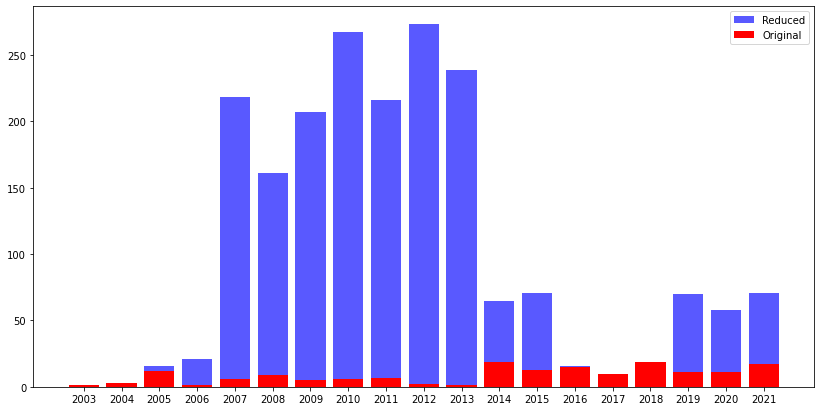

In [15]:
fig, ax = plt.subplots(figsize=(14,7))
years = [x for x in range(2003,2022)]
ax.bar(years, info_per_year_snip["number_components"], linewidth=2.0,color='blue',label='Reduced',alpha=0.65)
ax.bar(years, info_per_year["number_components"], linewidth=2.0,color='red',label='Original',alpha=1)
ax.legend()
ax.set(xticks=years)
plt.show()

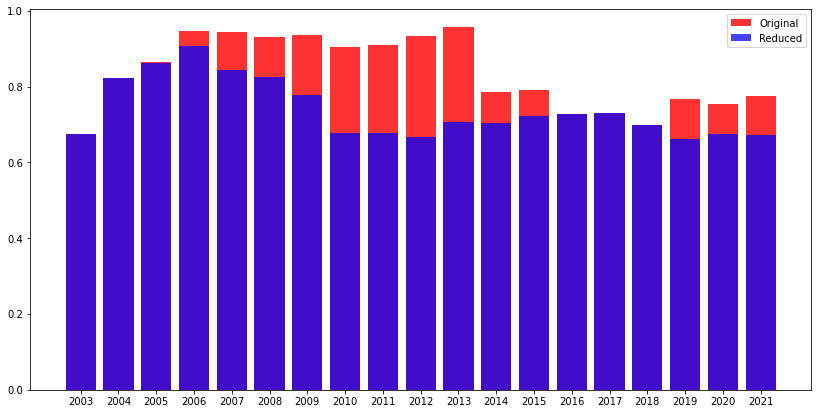

In [20]:
fig, ax = plt.subplots(figsize=(14,7))
years = [x for x in range(2003,2022)]

ax.bar(years, info_per_year["average_clustering"], linewidth=2.0,color='red',label='Original',alpha=0.8)
ax.bar(years, info_per_year_snip["average_clustering"], linewidth=2.0,color='blue',label='Reduced',alpha=0.74)
ax.legend()

ax.set(xticks=years)

plt.show()

# Visualising the networks
These graphs are large in node and edge size, so visualising them properly is a challenge as the created plots show us unpromising "hairballs". However, there might be still smaller groups we can discover.

In [21]:

def plot_graph(G):
  edge_colors=[]
  pos = nx.spring_layout(G, seed=123,iterations=16)
  #pos = nx.kamada_kawai_layout(G)  
  #pos= nx.spiral_layout(G,scale=3)

  G.edges(data=True) 
  for (u, v, w) in G.edges.data('weight'):
    edge_colors.append(w)

  #print(edge_colors)

  new_output = [100*s / sum(t) for t in [rankdata(edge_colors)] for s in t] 
  


  fig= plt.figure(figsize=(16,13))
  labels = nx.get_edge_attributes(G,'weight')
  nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
  
  nx.draw_networkx(G,pos,edge_color=edge_colors,
                   #width=new_output, 
                   edge_cmap=plt.cm.summer,node_color="#e6add8")  # use spring layout
  


In [22]:
def plot_graph_clean(G):
  edge_colors=[]

  pos = nx.kamada_kawai_layout(G)  
  #pos = nx.spring_layout(G, seed=123,iterations=16)

  for (u, v, w) in G.edges.data('weight'):
    edge_colors.append(w)

  fig= plt.figure(figsize=(16,13))

  nx.draw_networkx(G,pos,edge_color=edge_colors, with_labels=False,
                   edge_cmap=plt.cm.summer,node_color="#e6add8",node_size=57)  # use spring layout

While the small network (for year 2003) is easy to visualise with labes, the large ones are difficult to comprehend on a purely visual level even without any labels.

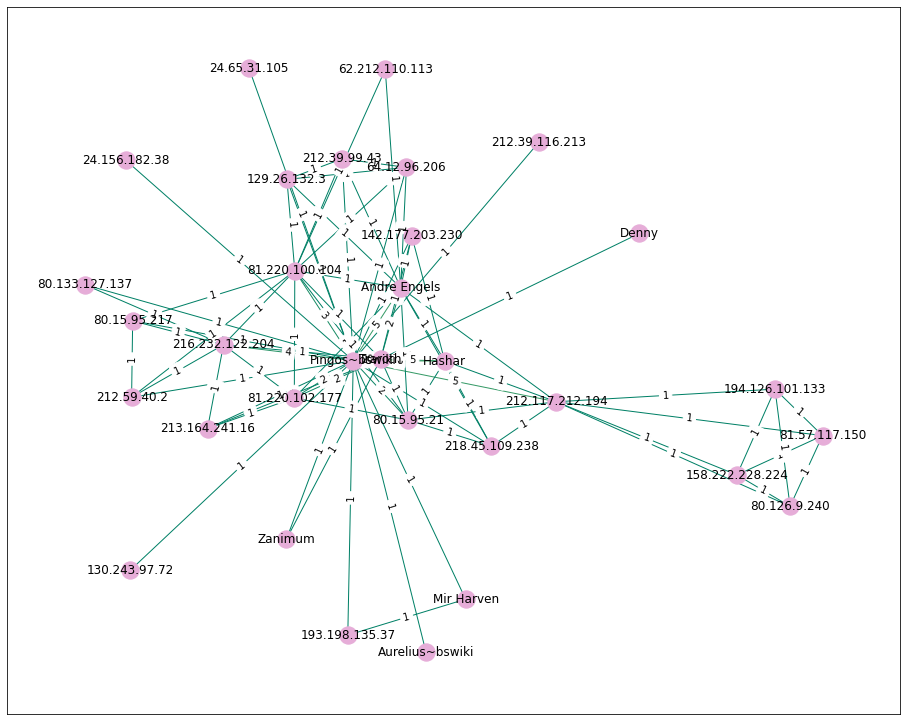

In [23]:
plot_graph(G_2003)

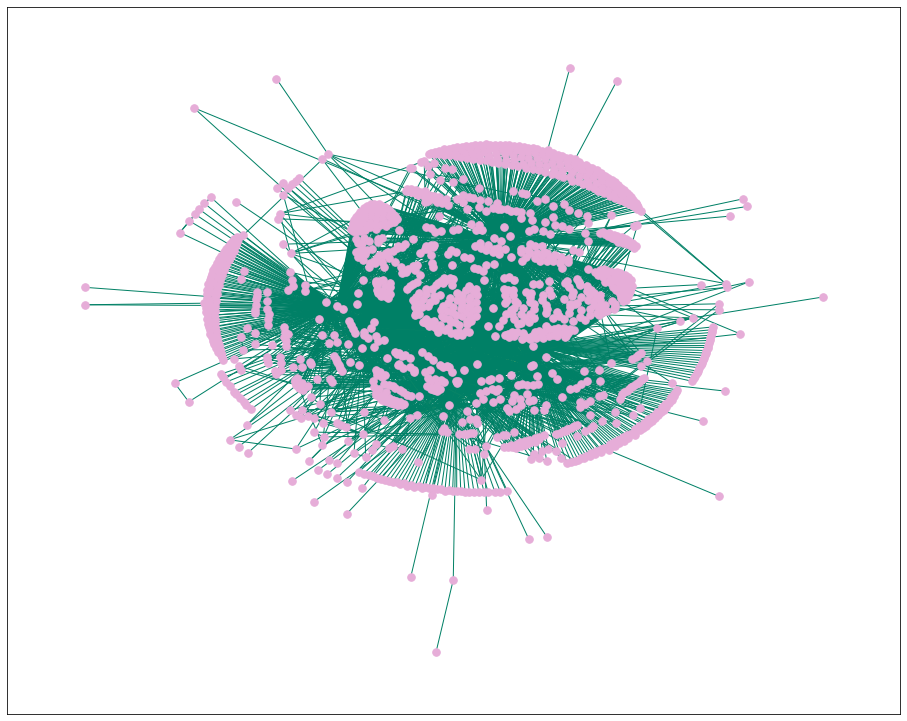

In [24]:
plot_graph_clean(G_2018)

#Community finding algorithms
Three algorithms are used: Label Propagation, Clique Percolation Method and Greedy Modularity Maximisation.
But first, we'll remove the isolated nodes, as they don't mean anything when defining a community.


In [30]:
for year in range(2003,2022):
  graphs[year-2003].remove_nodes_from(list(nx.isolates(graphs[year-2003])))
  

In [31]:
from networkx.algorithms.community import greedy_modularity_communities
graphs_greedy_mod=[]
for year in range(2003,2022):
  graphs_greedy_mod.append(list(greedy_modularity_communities(graphs[year-2003])))
 

In [32]:
graphs_label_propagation=[]
for year in range(2003,2022):
  graphs_label_propagation.append(list(nx.community.label_propagation_communities(graphs[year-2003])))
 

For CPM we will experiment later with the k parameter - size of the cliques. Here the size for the cliques used is 4.

In [40]:
graphs_k_clique=[]
for year in range(2003,2022):
  graphs_k_clique.append(list(k_clique_communities(graphs[year-2003], 4)))


# Plotting size distributions
Let's visualise the size distributions of the groups detected and how they change for every year.

First, let's take a look at how many groups each algorithm finds.
CPM results in most groups overall (however, we know that CPM will allow for some overlap between them) closely followed by LP results. The GMM finds noticeably less communities than the other two algorithms.

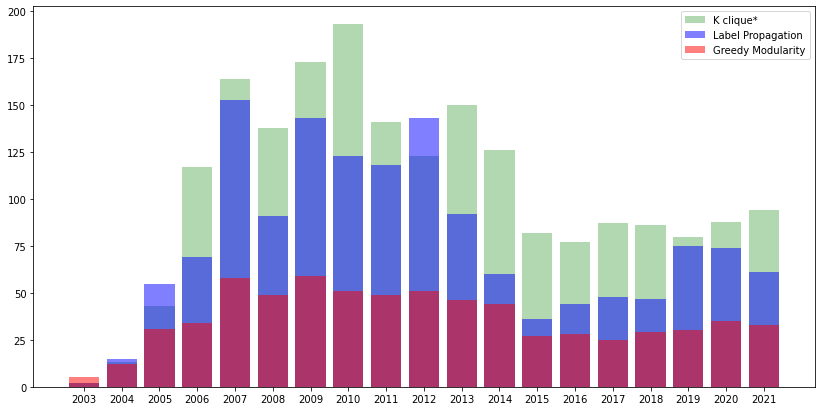

In [34]:
p_greedy_mod=[]
p_k_clique=[]
p_label_propagation=[]

for a in graphs_k_clique:
  p_k_clique.append((len(a)))

for a in graphs_greedy_mod :
  p_greedy_mod.append((len(a)))
for a in graphs_label_propagation:
  p_label_propagation.append((len(a)))


fig, ax = plt.subplots(figsize=(14,7))

years = [x for x in range(2003,2022)]

ax.bar(years, p_k_clique, linewidth=2.0,color='green',label='K clique*',alpha=0.3)
ax.bar(years, p_label_propagation, linewidth=2.0,color='blue',label='Label Propagation',alpha=0.5)
ax.bar(years, p_greedy_mod, linewidth=2.0,color='red',label='Greedy Modularity',alpha=0.5)

ax.legend()

ax.set(xticks=years)

plt.show()

Here we visualise the size distribution of the groups per algorithm

In [36]:
def pandas_plot(graph):

  df_width = max(len(x) for x in graph )

  plot_df=pd.DataFrame(columns=[a for a in range(df_width)])
  for year in range(2003,2022):
    row = np.full((df_width), np.nan)
    a=[]
    for i in range(len(graph[year-2003])):
      
      a.append(len(graph[year-2003][i]))
    a=np.sort(a) 
    a=np.flip(a)
    for i in range(len(a)): 
      row[i]=a[i]


    plot_df.loc[year]= pd.Series(row)

  #print(plot_df)


  plot_df.plot.bar(stacked=True,figsize=(17,12)).legend().remove()
  plt.figure()
 

### Label Propagation

Despite a large number of groups, their size dwarfs in comparison to the one large group present thorught the years.

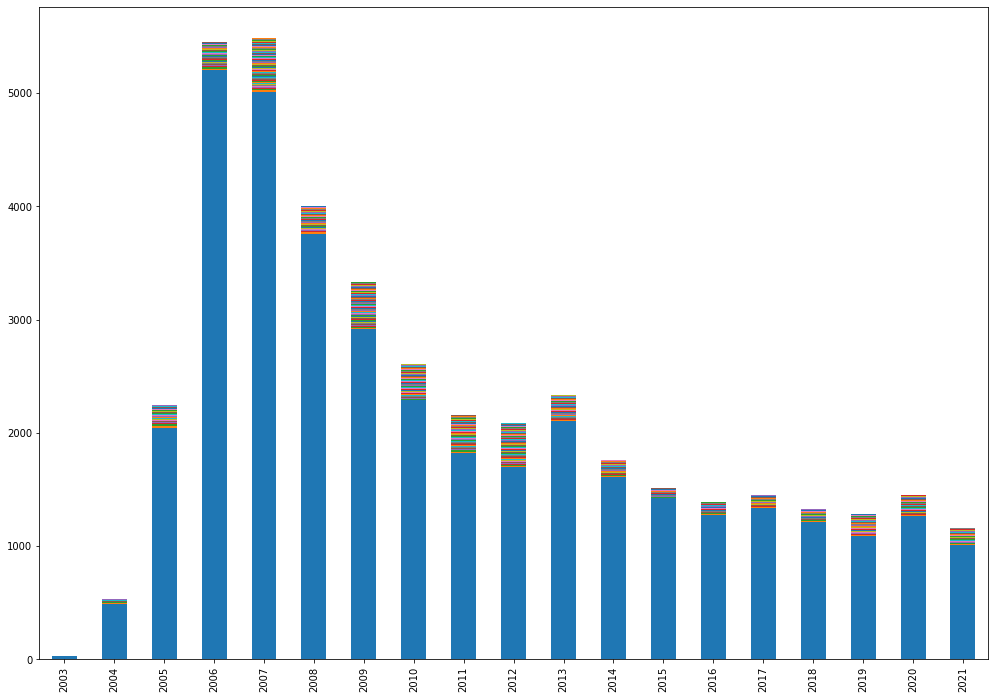

<Figure size 432x288 with 0 Axes>

In [ ]:
pandas_plot(graphs_label_propagation)

### Greedy Modularity Maximisation

GMM has found less groups than other two algorithms, but a few of these groups are more balanced in size, while we do see a number of tiny communities.

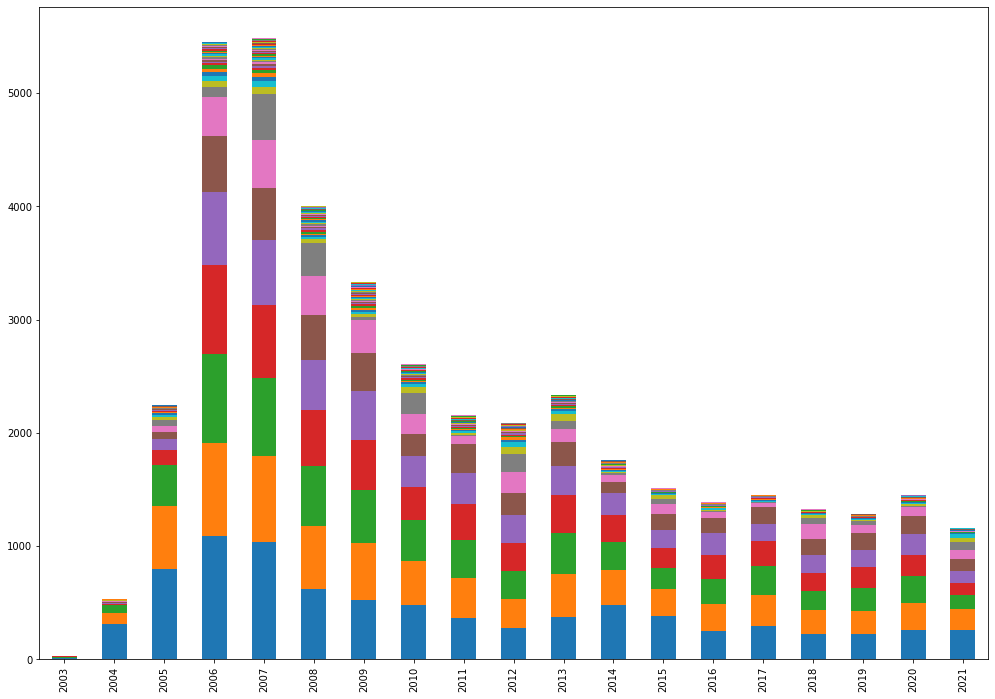

<Figure size 432x288 with 0 Axes>

In [ ]:
pandas_plot(graphs_greedy_mod)

### Clique Percolation Model

CPM for k=4 give results similar to the LP algorithm.

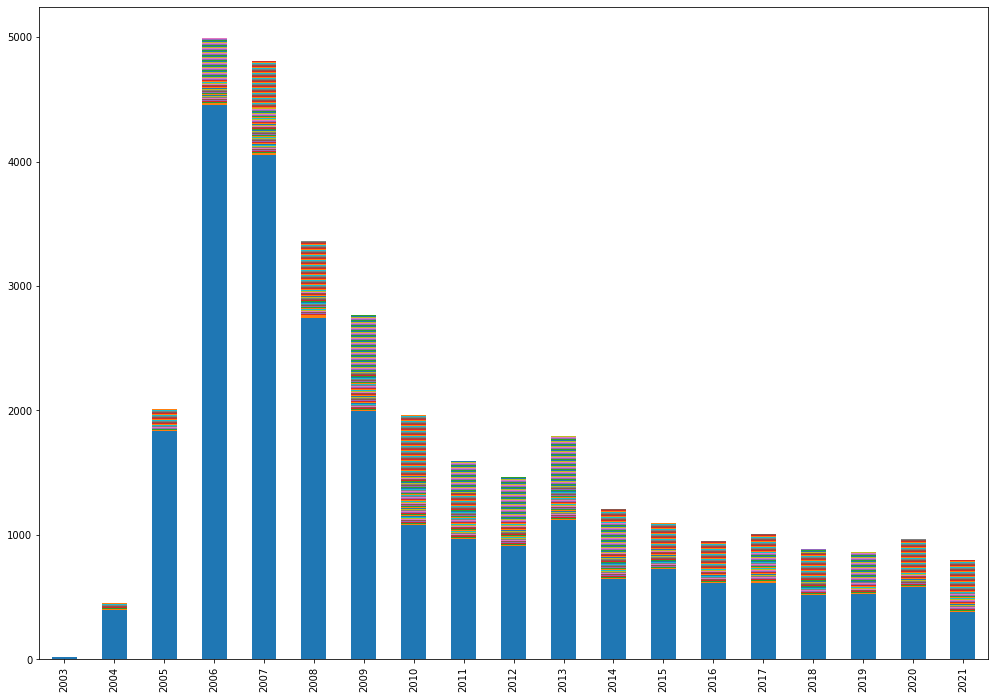

<Figure size 432x288 with 0 Axes>

In [37]:
pandas_plot(graphs_k_clique)

Altough we haven't yet removed the weak ties, let's try to take a look at what happens when we increase k

In [ ]:
graphs_k_clique=[]
for year in range(2003,2022):
  graphs_k_clique.append(list(k_clique_communities(graphs[year-2003], 10)))
 

For k=10 we still have a big number of small groups, but our overly large group has been taken apart soon after 2009.

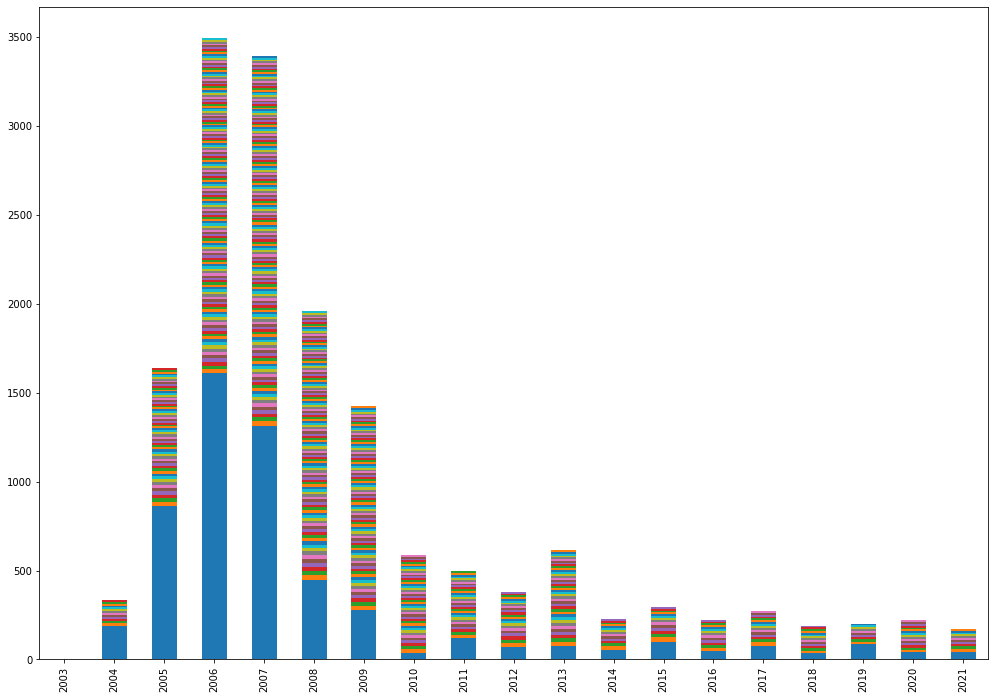

<Figure size 432x288 with 0 Axes>

In [ ]:
pandas_plot(graphs_k_clique)

In [38]:
graphs_k_clique=[]
for year in range(2003,2022):
  graphs_k_clique.append(list(k_clique_communities(graphs[year-2003], 17)))


For k=17 there is certainly smaller amount of groups, which are now larger in size, but we can see that for later years finding such a connected group is a challenge, showing us that co-authorship communities have grown more sporadic and more niche over time.

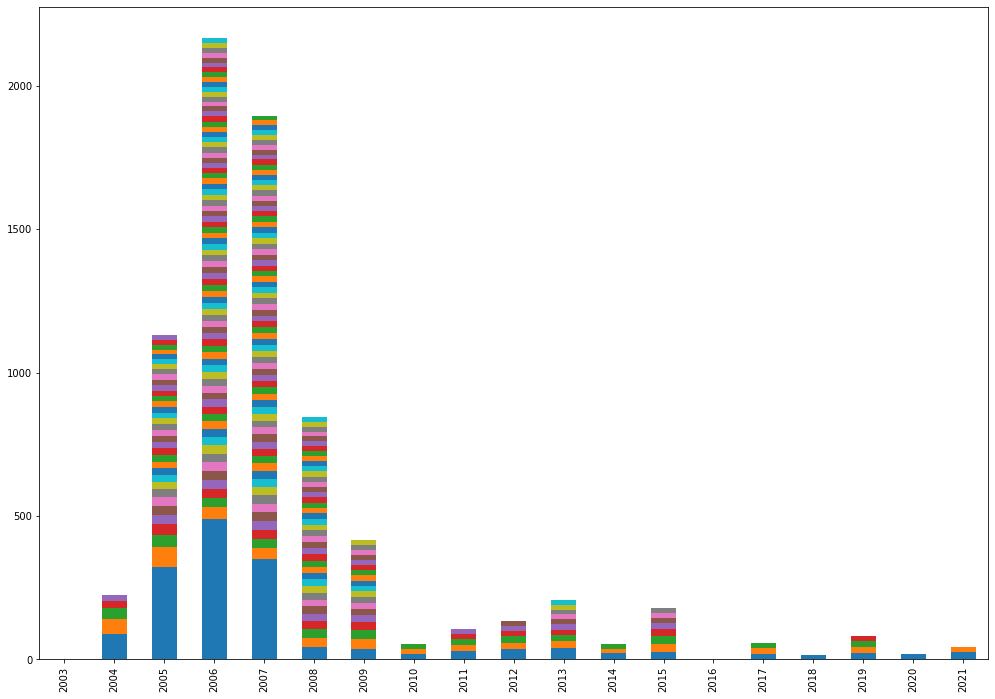

<Figure size 432x288 with 0 Axes>

In [39]:
pandas_plot(graphs_k_clique)

# Removing weak co-authorships
We can say if the number of articles shared between two users is below a threshold, then their co-authorship is more a matter of chance than a group effort. 
Let us remove every edge with a weight lesser than 4 (and any isolating nodes that occur this way). This makes for smaller networks, whose basic properties are also shown below. Let's see what difference this makes for the community finding algorithms.   

##Basic network properties (2)

In [42]:
graphsss=[G_2003.copy(),G_2004.copy(),G_2005.copy(),G_2006.copy(),G_2007.copy(),G_2008.copy(),G_2009.copy(),
        G_2010.copy(),G_2011.copy(),G_2012.copy(),G_2013.copy(),G_2014.copy(),G_2015.copy(),
        G_2016.copy(),G_2017.copy(),G_2018.copy(),G_2019.copy(),G_2020.copy(),G_2021.copy()]

In [43]:
info_per_year_snip = pd.DataFrame(columns=["number_of_nodes","number_of_edges","average_degree",
                                       "number_components", "average_clustering"])
 
for year in range(2003,2022):
  edges_one = [(v,d) for v, d, a in graphsss[year-2003].edges(data=True) if a['weight'] < 3]
  graphsss[year-2003].remove_edges_from(edges_one)

  bots = [a   for  a in graphsss[year-2003].nodes() if a.endswith(tuple (['bot', 'BoT','Bot', 'BOT']))  ]
  graphsss[year-2003].remove_nodes_from(bots)
  graphsss[year-2003].remove_nodes_from(list(nx.isolates(graphsss[year-2003])))
  info_per_year_snip.loc[year]=[graphsss[year-2003].number_of_nodes(),graphsss[year-2003].number_of_edges(),
                                np.mean([d for _, d in graphsss[year-2003].degree()]),
                         number_connected_components(graphsss[year-2003]),nx.average_clustering(graphsss[year-2003])]
  
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(info_per_year_snip)                         

      number_of_nodes  number_of_edges  average_degree  number_components  \
2003              7.0              7.0        2.000000                1.0   
2004             42.0            120.0        5.714286                1.0   
2005            171.0            786.0        9.192982                1.0   
2006            289.0           1275.0        8.823529                1.0   
2007            209.0           1023.0        9.789474                1.0   
2008            143.0            537.0        7.510490                1.0   
2009            117.0            416.0        7.111111                2.0   
2010             66.0            156.0        4.727273                1.0   
2011             56.0            200.0        7.142857                1.0   
2012             47.0            132.0        5.617021                1.0   
2013             65.0            167.0        5.138462                1.0   
2014             63.0            159.0        5.047619                1.0   

A sharp drop across every metric, as expected. Curiously, almost every graph is a singular component, except for year 2009. 

Visualising these properties on barcharts...

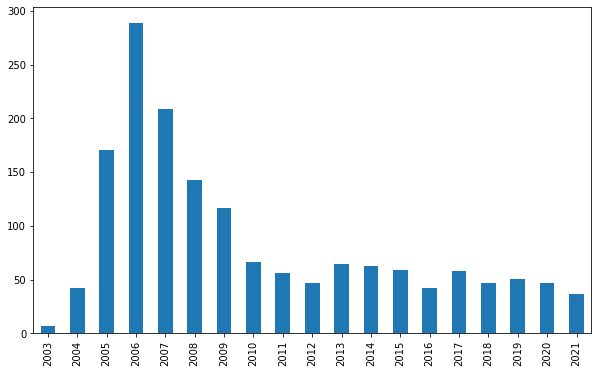

In [ ]:
info_per_year_snip["number_of_nodes"].plot(kind='bar',figsize=(10,6))

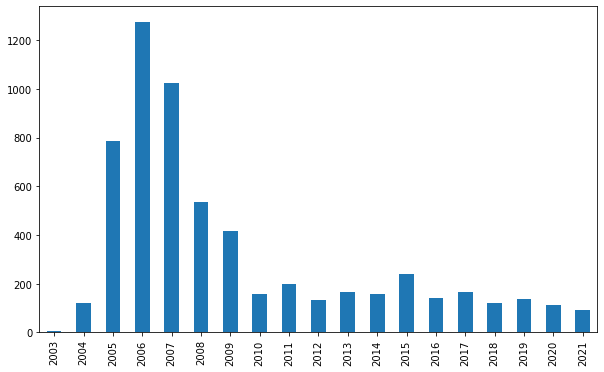

In [ ]:
info_per_year_snip["number_of_edges"].plot(kind='bar',figsize=(10,6))

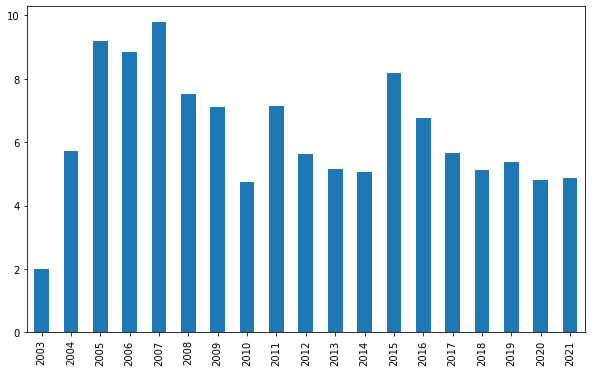

In [ ]:
info_per_year_snip["average_degree"].plot(kind='bar',figsize=(10,6))

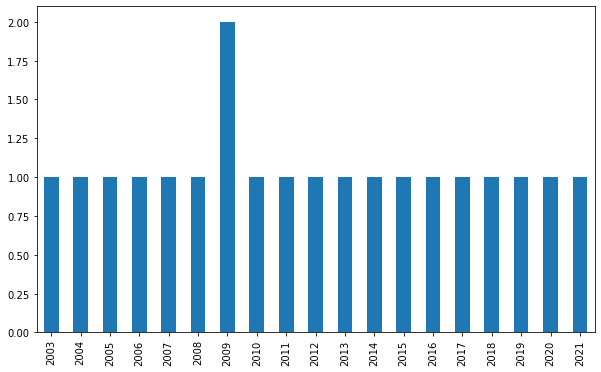

In [ ]:
info_per_year_snip["number_components"].plot(kind='bar',figsize=(10,6))

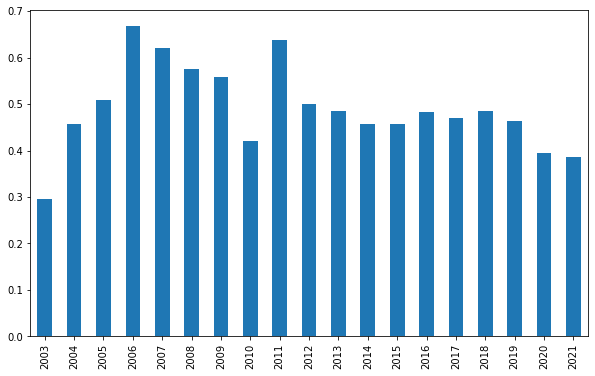

In [ ]:
info_per_year_snip["average_clustering"].plot(kind='bar',figsize=(10,6))

## Visualisations (2)

Let us try to visualise some of these graphs now that they have greatly reduced in size. 

We can still see a dominant large centre group and a great deal of nodes with a degree of one.

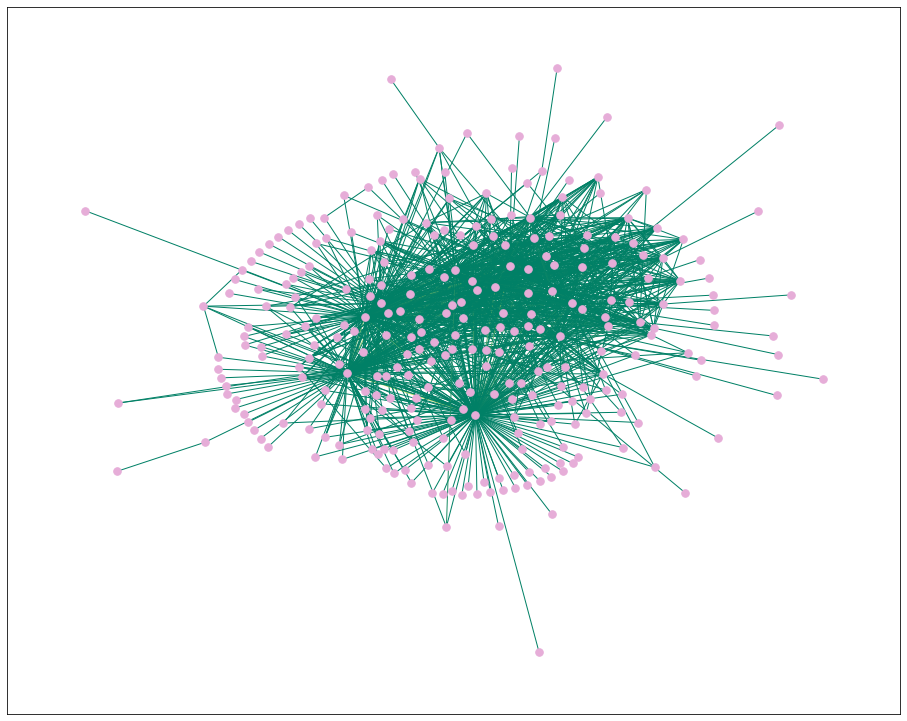

In [ ]:
plot_graph_clean(graphsss[2006-2003])

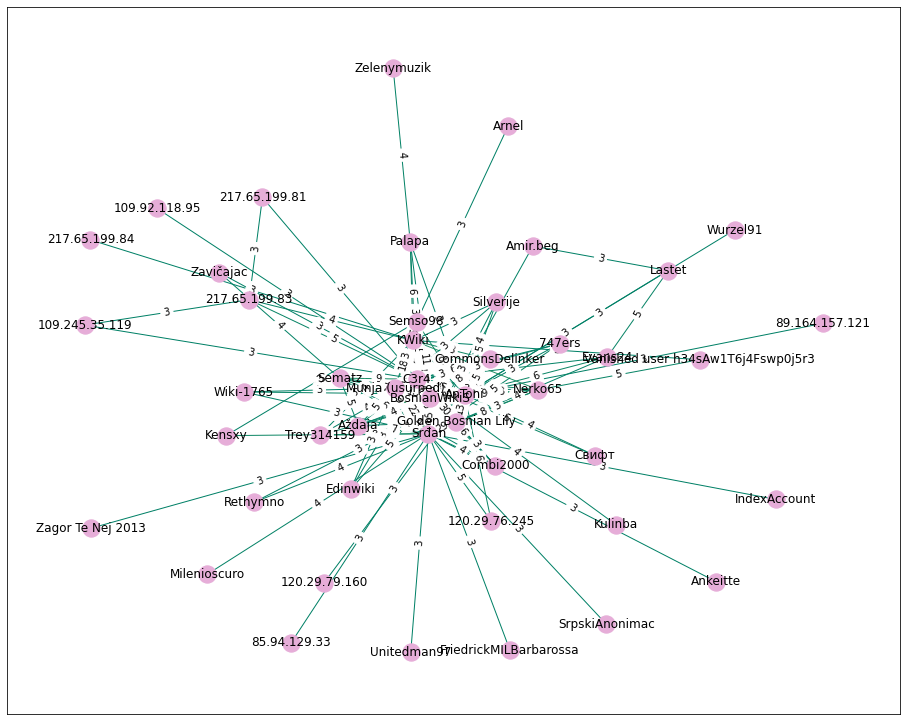

In [ ]:
plot_graph(graphsss[2018-2003])

##Community finding algorithms (2)

Once again we apply the community finding algorithms to see what are the strongly connected groups.

In [56]:
graphsss_greedy_mod=[]
for year in range(2003,2022):
  graphsss_greedy_mod.append(list(greedy_modularity_communities(graphsss[year-2003])))
 

In [57]:
graphsss_label_propagation=[]
for year in range(2003,2022):
  graphsss_label_propagation.append(list(nx.community.label_propagation_communities(graphsss[year-2003])))
 

In [58]:
graphsss_k_clique=[]
for year in range(2003,2022):
  graphsss_k_clique.append(list(k_clique_communities(graphsss[year-2003], 4)))


##Plotting group size distributions (2)

First, let's take a look at how many groups each algorithm finds.

This time around there is a very small number of groups found. For a change, it is GMM that results in the most groups, but this is still very far from the original numbers. LP find 1 to 3 groups a year, while CPM finds even less, sometimes not even a single one.

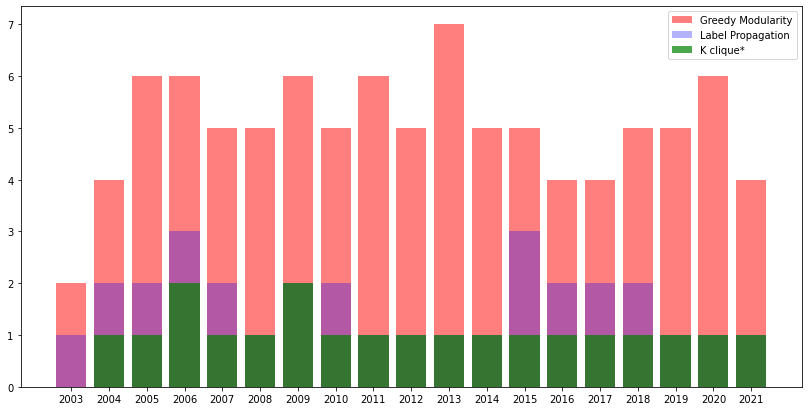

In [59]:
pp_greedy_mod=[]
pp_k_clique=[]
pp_label_propagation=[]

for a in graphsss_k_clique:
  pp_k_clique.append((len(a)))

for a in graphsss_greedy_mod :
  pp_greedy_mod.append((len(a)))
for a in graphsss_label_propagation:
  pp_label_propagation.append((len(a)))


fig, ax = plt.subplots(figsize=(14,7))

years = [x for x in range(2003,2022)]
ax.bar(years, pp_greedy_mod, linewidth=2.0,color='red',label='Greedy Modularity',alpha=0.5)
ax.bar(years, pp_label_propagation, linewidth=2.0,color='blue',label='Label Propagation',alpha=0.3)
ax.bar(years, pp_k_clique, linewidth=2.0,color='green',label='K clique*',alpha=0.7)


ax.legend()

ax.set(xticks=years)

plt.show()

### Label Propagation

In cases where more than one group was detected, it is almost insignificant in size.

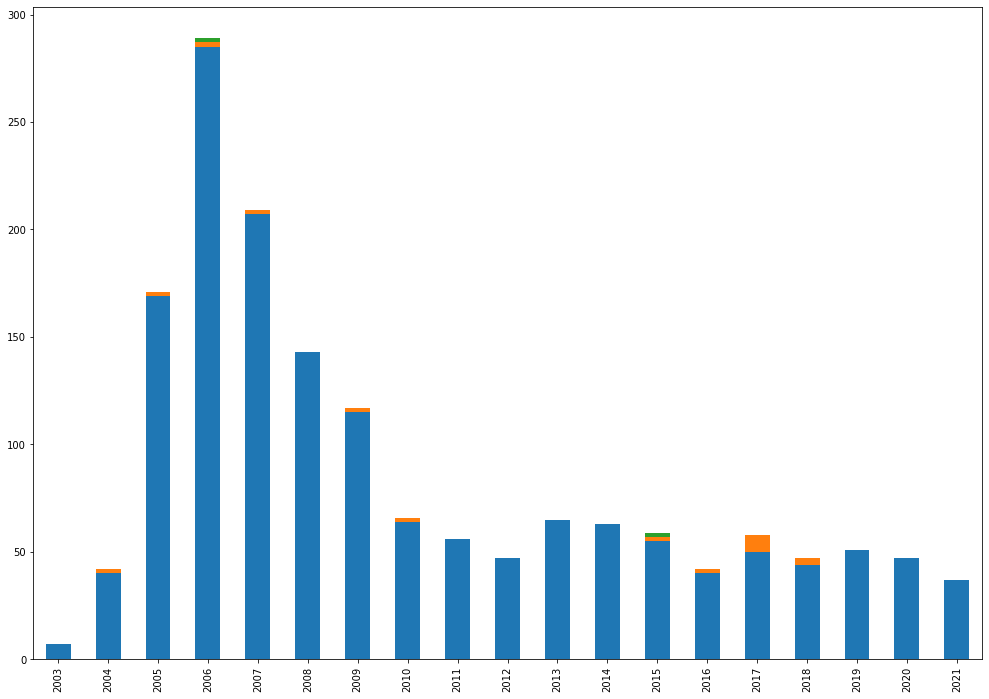

<Figure size 432x288 with 0 Axes>

In [ ]:
pandas_plot(graphsss_label_propagation)

### Greedy Modularity Maximisation

GMM maintains a more balanced split between the groups, with only some being very small and other groups being relatively the same in size, compared to each other.

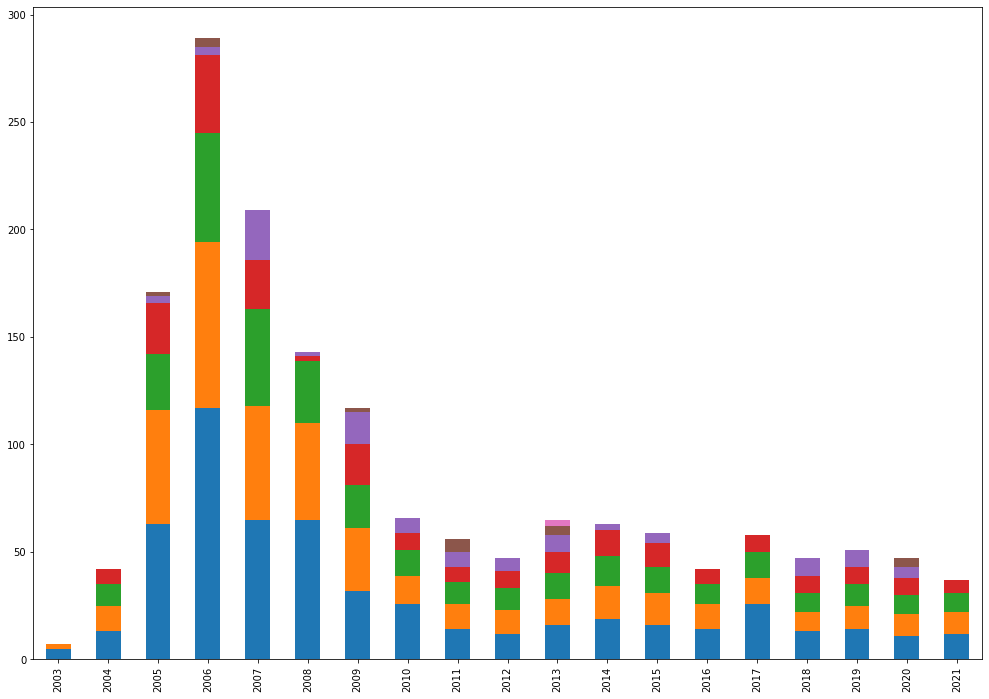

<Figure size 432x288 with 0 Axes>

In [ ]:
pandas_plot(graphsss_greedy_mod)

### Clique Percolation Model

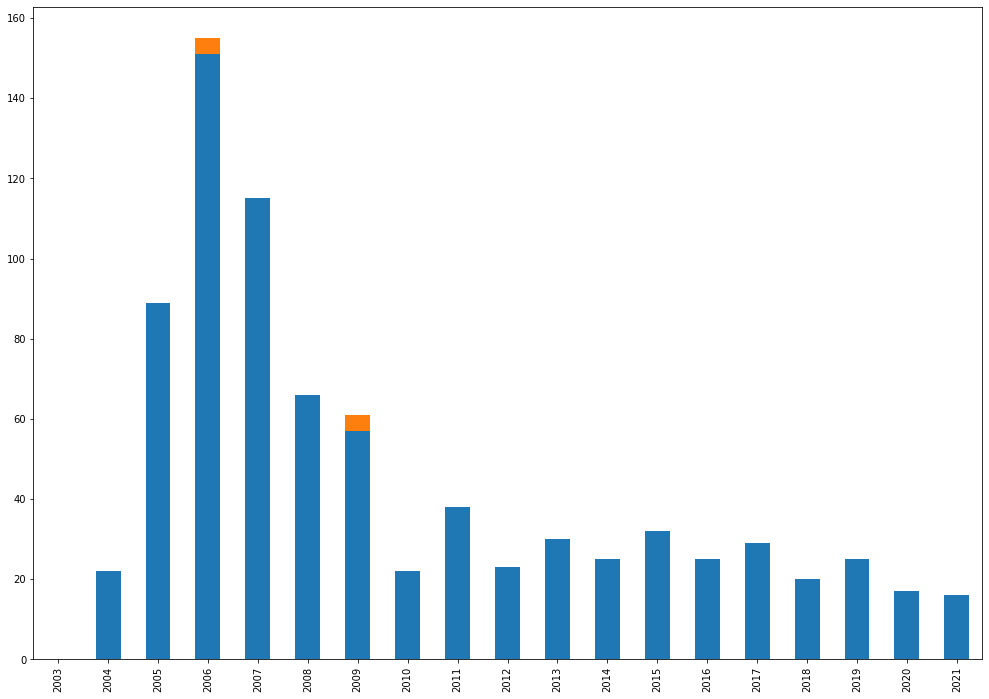

<Figure size 432x288 with 0 Axes>

In [47]:
pandas_plot(graphsss_k_clique)

As we increase the clique size paramater, we don't seem to able to deviate from the one large dominant group successfully on a yearly level.

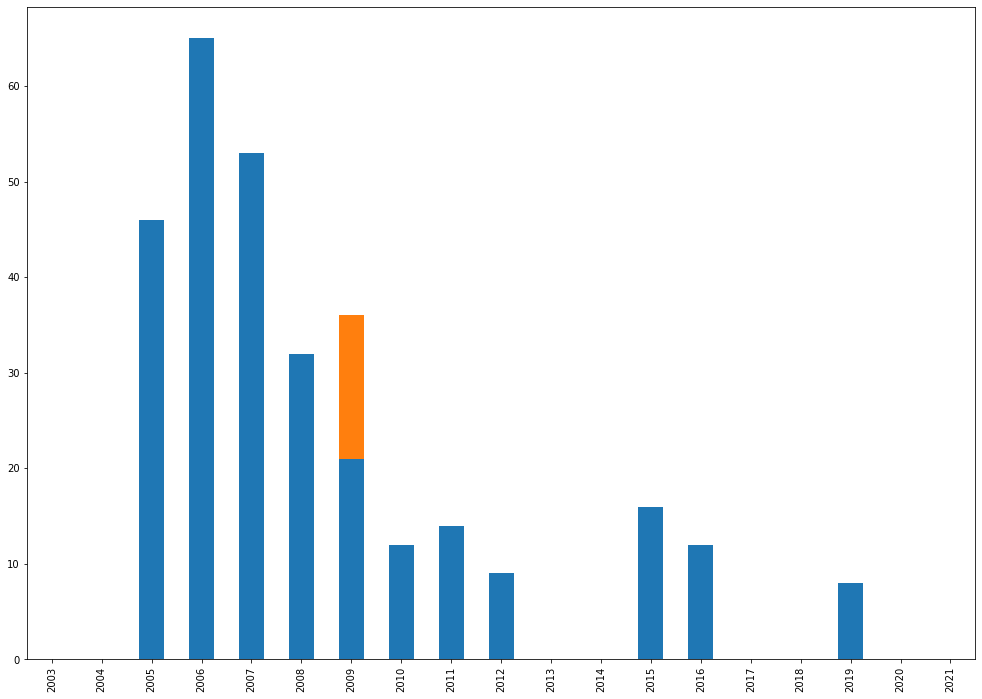

<Figure size 432x288 with 0 Axes>

In [60]:
graphsss_k_clique=[]
for year in range(2003,2022):
  graphsss_k_clique.append(list(k_clique_communities(graphsss[year-2003], 8)))
pandas_plot(graphsss_k_clique)

#Additional insights
Now that we have seen that the Bosnian wikipedia community tends to form one large group, let's see what else we can investigate.

### General overlap
We can see how many users remain consistent through the years

In [ ]:
for i in range(18):
  a=(np.intersect1d(list(graphs[i].nodes()),list(graphs[i+1].nodes())))
  print("Year:", i+2003,"\t Overlap:",len(a) )

Year: 2003 	 Overlap: 8
Year: 2004 	 Overlap: 38
Year: 2005 	 Overlap: 173
Year: 2006 	 Overlap: 305
Year: 2007 	 Overlap: 238
Year: 2008 	 Overlap: 172
Year: 2009 	 Overlap: 133
Year: 2010 	 Overlap: 122
Year: 2011 	 Overlap: 120
Year: 2012 	 Overlap: 120
Year: 2013 	 Overlap: 111
Year: 2014 	 Overlap: 92
Year: 2015 	 Overlap: 76
Year: 2016 	 Overlap: 87
Year: 2017 	 Overlap: 93
Year: 2018 	 Overlap: 100
Year: 2019 	 Overlap: 111
Year: 2020 	 Overlap: 92


We can even find users who have been contributing for at least a decade.

In [ ]:
for i in range(10):
  a=(np.intersect1d(list(graphs[i].nodes()),list(graphs[i+1].nodes())))
  a=(np.intersect1d(a,list(graphs[i+2].nodes())))
  a=(np.intersect1d(a,list(graphs[i+3].nodes())))
  a=(np.intersect1d(a,list(graphs[i+4].nodes())))
  a=(np.intersect1d(a,list(graphs[i+5].nodes())))
  a=(np.intersect1d(a,list(graphs[i+6].nodes())))
  a=(np.intersect1d(a,list(graphs[i+7].nodes())))
  a=(np.intersect1d(a,list(graphs[i+8].nodes())))
  a=(np.intersect1d(a,list(graphs[i+9].nodes())))
  print("Year:", i+2012,"\t Overlap:",len(a),"\n",a)

 

Year: 2012 	 Overlap: 0 
 []
Year: 2013 	 Overlap: 0 
 []
Year: 2014 	 Overlap: 3 
 ['AdnanSa' 'Mediteran' 'Palapa']
Year: 2015 	 Overlap: 3 
 ['AdnanSa' 'C3r4' 'Palapa']
Year: 2016 	 Overlap: 5 
 ['AdnanSa' 'AnToni' 'C3r4' 'CommonsDelinker' 'Palapa']
Year: 2017 	 Overlap: 6 
 ['AdnanSa' 'AnToni' 'C3r4' 'CommonsDelinker' 'Palapa' 'WizardOfOz']
Year: 2018 	 Overlap: 7 
 ['AdnanSa' 'AnToni' 'C3r4' 'CommonsDelinker' 'Palapa' 'Silverije'
 'WizardOfOz']
Year: 2019 	 Overlap: 8 
 ['AdnanSa' 'AnToni' 'C3r4' 'CommonsDelinker' 'KWiki' 'Palapa' 'Silverije'
 'WizardOfOz']
Year: 2020 	 Overlap: 9 
 ['AdnanSa' 'AnToni' 'CommonsDelinker' 'Edinwiki' 'KWiki' 'Palapa' 'Sematz'
 'Silverije' 'Tegel']
Year: 2021 	 Overlap: 9 
 ['AdnanSa' 'AnToni' 'BosnianWikiS' 'CommonsDelinker' 'KWiki' 'Nerko65'
 'Palapa' 'Silverije' 'Tegel']


....and whether they were part of the big central group or more specialised.

In [ ]:
for i in range(10):
  a=(np.intersect1d(list(graphs_label_propagation[i][0]),list(graphs_label_propagation[i+1][0])))
  a=(np.intersect1d(a,list(graphs_label_propagation[i+2][0])))
  a=(np.intersect1d(a,list(graphs_label_propagation[i+3][0])))
  a=(np.intersect1d(a,list(graphs_label_propagation[i+4][0])))
  a=(np.intersect1d(a,list(graphs_label_propagation[i+5][0])))
  a=(np.intersect1d(a,list(graphs_label_propagation[i+6][0])))
  a=(np.intersect1d(a,list(graphs_label_propagation[i+7][0])))
  a=(np.intersect1d(a,list(graphs_label_propagation[i+8][0])))
  a=(np.intersect1d(a,list(graphs_label_propagation[i+9][0])))
  print("Year:", i+2003,"\t Overlap:",len(a),"\n",a)

Year: 2003 	 Overlap: 0 
 []
Year: 2004 	 Overlap: 0 
 []
Year: 2005 	 Overlap: 2 
 ['AdnanSa' 'Palapa']
Year: 2006 	 Overlap: 3 
 ['AdnanSa' 'C3r4' 'Palapa']
Year: 2007 	 Overlap: 5 
 ['AdnanSa' 'AnToni' 'C3r4' 'CommonsDelinker' 'Palapa']
Year: 2008 	 Overlap: 6 
 ['AdnanSa' 'AnToni' 'C3r4' 'CommonsDelinker' 'Palapa' 'WizardOfOz']
Year: 2009 	 Overlap: 7 
 ['AdnanSa' 'AnToni' 'C3r4' 'CommonsDelinker' 'Palapa' 'Silverije'
 'WizardOfOz']
Year: 2010 	 Overlap: 7 
 ['AdnanSa' 'AnToni' 'C3r4' 'CommonsDelinker' 'KWiki' 'Palapa' 'Silverije']
Year: 2011 	 Overlap: 8 
 ['AdnanSa' 'AnToni' 'CommonsDelinker' 'Edinwiki' 'KWiki' 'Palapa' 'Sematz'
 'Silverije']
Year: 2012 	 Overlap: 8 
 ['AdnanSa' 'AnToni' 'BosnianWikiS' 'CommonsDelinker' 'KWiki' 'Nerko65'
 'Palapa' 'Silverije']


###Moved groups
We can also list out those users who remain the following year but moved from the dominant group to a more niche community.

In [ ]:
for i in range(18):
  a=(np.intersect1d(list(graphs[i].nodes()),list(graphs[i+1].nodes())))
  b=(list(graphs_label_propagation[i][0]))

  print("Moved to different group:" )
  print(np.setdiff1d(a, b),"\n")

Moved to different group:
['80.126.9.240'] 

Moved to different group:
['195.101.52.174' '80.65.81.206' 'Robin Hood~bswiki'] 

Moved to different group:
['195.222.36.210' '195.66.160.3' '202.7.166.168' '212.14.16.131'
 '213.202.85.44' '217.91.16.44' '62.245.207.10' '80.65.91.102'
 'Jaro~bswiki'] 

Moved to different group:
['62.113.158.67' '82.172.135.170' 'Brdo' 'Stanislav~bswiki'] 

Moved to different group:
['134.93.51.36' '193.198.70.211' '194.183.77.163' '200.222.27.249'
 '72.12.144.115' '80.24.153.79' '80.55.141.202' 'DerHexer'] 

Moved to different group:
['217.211.158.156' '217.65.194.4' '62.8.252.58' '91.185.96.74'
 'Antonio Lopez' 'DimDim72' 'GilliamJF' 'Markus cg1' 'Nbumbic' 'Stevanb'
 'Szupa' 'Teekkari'] 

Moved to different group:
['109.105.193.2' '213.143.69.158' '77.74.230.67' '80.93.254.12'
 '87.250.116.6' 'Angel ivanov angelov' 'BHS~bswiki' 'Dalibor Bosits'
 'President23' 'Sebleouf' 'TheMiner' 'Vituzzu' 'Wikijens' 'Woudloper'] 

Moved to different group:
['195.178.62.1

#Conclusion and further research
We have seen that there is a wide range of types of users who contribute on Bosnian Wikipedia, from dedicated editors who are present for over a decade to users who sporadically edited an article. Most interesting has been the result from the Clique Percolation Method and Label Propagation algorthims which imply that there is one large group, while the Greedy Modularity Maximisation has been able to find more separate groups, even with the weak co-authorship links removed.
Looking at the overlap between the groups tells us exactly who left the group to join another one, or simply stopped being as active on Wikipedia. Some of the users that persisted over the years aren't even logged in, instead their revisions remain marked with only their IP adress for years.

Directions for future research regards to this problem would include analysis of Wikipedia articles in other languages in order to observe how a language may define a community of editors, looking into other community finding algorithms and a more detailed analysis of the groups found.


#References and materials
 
[1]   https://dumps.wikimedia.org/bswiki/20211201/ (2021.12.02.)

[2]   https://networkx.org/documentation/stable/reference/algorithms/community.html (2021.12.04.)

[3]  https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html#network-communities (2021.12.04.)

[4] Orosz K., Farkas I.J., Pollner P.: Quantifying the changing role of past publications. Scientometrics 108, 829 (2016)

[5] Keegan B., Gergle D., Contractor N.: 
Do Editors or Articles Drive Collaboration? Multilevel Statistical Network Analysis of Wikipedia Coauthorship. CSCW'12 - Proceedings of the ACM 2012 Conference on Computer Supported Cooperative Work, 427-436 (2012)